In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    confusion_matrix, classification_report, balanced_accuracy_score
)


In [2]:
import pandas as pd


usagers_df = pd.read_csv('/Users/mahakhadraoui/ramp-challenge/data/usagers-2023.csv', sep=';')
vehicules_df = pd.read_csv('/Users/mahakhadraoui/ramp-challenge/data/vehicules-2023.csv', sep=';')
lieux_df = pd.read_csv('/Users/mahakhadraoui/ramp-challenge/data/lieux-2023.csv', sep=';', low_memory=False)
caract_df = pd.read_csv('/Users/mahakhadraoui/ramp-challenge/data/caract-2023.csv', sep=';')

print("Usagers Data:")
print(usagers_df.head())

print("\nVehicules Data:")
print(vehicules_df.head())

print("\nLieux Data:")
print(lieux_df.head())

print("\nCaracteristiques Data:")
print(caract_df.head())

Usagers Data:
        Num_Acc    id_usager  id_vehicule num_veh  place  catu  grav  sexe  \
0  202300000001  203 851 184  155 680 557     A01      1     1     4     1   
1  202300000002  203 851 182  155 680 556     A01      1     1     1     2   
2  202300000002  203 851 183  155 680 556     A01     10     3     3     1   
3  202300000003  203 851 180  155 680 554     B01      1     1     3     1   
4  202300000003  203 851 181  155 680 555     A01      1     1     1     2   

   an_nais  trajet  secu1  secu2  secu3  locp actp  etatp  
0   1978.0       5      2      0     -1    -1   -1     -1  
1   1997.0       9      1      0     -1    -1   -1     -1  
2   1997.0       9      0     -1     -1     2    3      1  
3   1987.0       0      2      6      0     0    0     -1  
4   1984.0       0      1      0      0     0    0     -1  

Vehicules Data:
        Num_Acc  id_vehicule num_veh  senc  catv  obs  obsm  choc  manv  \
0  202300000001  155 680 557     A01     1    30    0     0     5

In [3]:
# Fusion en gardant `id_usager` comme unité principale
df = usagers_df.copy()  # On commence avec les usagers

# Ajout des informations des véhicules (via `id_vehicule`)
df = df.merge(vehicules_df, on=["Num_Acc", "id_vehicule"], how="left")

# Ajout des informations du lieu de l'accident (via `Num_Acc`, car commun à tous les usagers)
df = df.merge(lieux_df, on="Num_Acc", how="left")

# Ajout des informations générales de l'accident (via `Num_Acc`)
df = df.merge(caract_df, on="Num_Acc", how="left")

In [4]:
df.shape

(163683, 56)

In [8]:
# Convertir `hrmn` en heure et minute
df["heure"] = pd.to_datetime(df["hrmn"], format="%H:%M", errors="coerce").dt.hour
df["minute"] = pd.to_datetime(df["hrmn"], format="%H:%M", errors="coerce").dt.minute

# Remplacer les NaN dans `heure` et `minute` par une valeur par défaut (ex: 0)
df["heure"].fillna(0, inplace=True)
df["minute"].fillna(0, inplace=True)

# Conversion en `int`
df["heure"] = df["heure"].astype(int)
df["minute"] = df["minute"].astype(int)

# Création du timestamp
df["datetime"] = pd.to_datetime(df[["an", "mois", "jour"]].astype(str).agg('-'.join, axis=1)) \
                 + pd.to_timedelta(df["heure"], unit="h") + pd.to_timedelta(df["minute"], unit="m")

# Création des nouvelles variables temporelles
df["week_day"] = df["datetime"].dt.weekday  # Jour de la semaine (0 = Lundi, 6 = Dimanche)
df["weekend"] = (df["week_day"] >= 5).astype(int)  # 1 si week-end, 0 sinon

# Correction de `hour_category` en évitant les NaN
df["hour_category"] = pd.cut(df["heure"], bins=[-1, 6, 12, 18, 24], labels=[0, 1, 2, 3])
df["hour_category"].fillna(0, inplace=True)  # Remplacement des NaN par la catégorie 0
df["hour_category"] = df["hour_category"].astype(int)  # Conversion finale en `int`

# Suppression des colonnes brutes
df.drop(columns=["jour", "mois", "an", "hrmn", "heure", "minute", "datetime"], inplace=True)

# Vérification finale
print(df.head())


/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/2257972077.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["heure"].fillna(0, inplace=True)
/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/2257972077.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

        Num_Acc    id_usager  id_vehicule num_veh_x  place  catu  grav  sexe  \
0  202300000001  203 851 184  155 680 557       A01      1     1     4     1   
1  202300000001  203 851 184  155 680 557       A01      1     1     4     1   
2  202300000002  203 851 182  155 680 556       A01      1     1     1     2   
3  202300000002  203 851 183  155 680 556       A01     10     3     3     1   
4  202300000003  203 851 180  155 680 554       B01      1     1     3     1   

   an_nais  trajet  ...  agg  int  atm  col                        adr  \
0   1978.0       5  ...    2    4    2    7              RUE DE RIVOLI   
1   1978.0       5  ...    2    4    2    7              RUE DE RIVOLI   
2   1997.0       9  ...    2    1    3    6            Avenue de Paris   
3   1997.0       9  ...    2    1    3    6            Avenue de Paris   
4   1987.0       0  ...    2    3    2    1  Avenue du Général Leclerc   

           lat        long  week_day  weekend  hour_category  
0  48,86638

/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/2257972077.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["hour_category"].fillna(0, inplace=True)  # Remplacement des NaN par la catégorie 0


In [9]:
# Création de la colonne 'securite'
df["securite"] = ((df["secu1"] > 0) | (df["secu2"] > 0) | (df["secu3"] > 0)).astype(int)

# Création de la colonne 'age'
current_year = 2023 
df['age'] = current_year - df['an_nais']

# Suppression des colonnes inutiles
cols_to_drop = ["num_veh", "adr", "dep", "com", "v1", "v2", "pr", "pr1", "id_usager", "id_vehicule", "Num_Acc", "secu2", "secu3", "secu1", "an_nais"]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# Suppression des lignes où grav == -1
df = df[df["grav"] != -1]





In [10]:
# Afficher le nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()

# Afficher uniquement les colonnes qui ont des valeurs manquantes
missing_values = missing_values[missing_values > 0]

print(" Nombre de valeurs manquantes par colonne :\n")
print(missing_values)


 Nombre de valeurs manquantes par colonne :

occutc    160804
voie       28378
lartpc    163449
age         3356
dtype: int64


In [11]:
df.drop(columns=["occutc", "lartpc", "voie"], axis=1, inplace=True)
df["age"].fillna(df["age"].mean(), inplace=True)

/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/629070630.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].mean(), inplace=True)


In [12]:
# Sélection des colonnes non numériques
non_numeric_cols = df.select_dtypes(exclude=["number"]).columns

# Affichage des premières valeurs pour chaque colonne non numérique
print("Colonnes non numériques et quelques instances :\n")
for col in non_numeric_cols:
    print(f" {col}:")
    print(df[col].dropna().unique()[:5])  # Affiche jusqu'à 5 valeurs uniques de la colonne
    print("-" * 40)

Colonnes non numériques et quelques instances :

 num_veh_x:
['A01' 'B01' 'C01' 'D01' 'Z01']
----------------------------------------
 actp:
[' -1' '3' '0' '1' '5']
----------------------------------------
 num_veh_y:
['A01' 'B01' 'C01' 'D01' 'Z01']
----------------------------------------
 nbv:
['2' '1' '3' '4' '5']
----------------------------------------
 larrout:
[' -1' '12' '3' '14' '5,5']
----------------------------------------
 lat:
['48,86638600' '48,84547782' '48,76240000' '48,73248432' '48,78581000']
----------------------------------------
 long:
['2,32347100' '2,42868146' '2,40655000' '2,44687575' '2,49217000']
----------------------------------------


In [13]:
print("Type de la colonne nbv :", df["nbv"].dtype)
print("Valeurs uniques dans nbv :")
print(df["nbv"].unique())


Type de la colonne nbv : object
Valeurs uniques dans nbv :
['2' '1' '3' '4' '5' ' -1' '6' '0' '8' '7' '10' '#VALEURMULTI' '9' '12'
 '11']


In [14]:
#  Supprimer les espaces inutiles
df["nbv"] = df["nbv"].astype(str).str.strip()

# Remplacer les valeurs non numériques par NaN
df["nbv"] = pd.to_numeric(df["nbv"], errors="coerce")  # Coerce transforme '#VALEURMULTI' en NaN

# Vérifier les valeurs NaN après correction
print("Valeurs uniques après conversion :", df["nbv"].unique())

#  Remplacer les NaN par la médiane (ou une autre valeur si nécessaire)
df["nbv"].fillna(df["nbv"].median(), inplace=True)

#  Convertir en entier si nécessaire
df["nbv"] = df["nbv"].astype(int)

# Vérification finale
print("Type après conversion :", df["nbv"].dtype)
print("Valeurs uniques après correction :", df["nbv"].unique())


Valeurs uniques après conversion : [ 2.  1.  3.  4.  5. -1.  6.  0.  8.  7. 10. nan  9. 12. 11.]
Type après conversion : int64
Valeurs uniques après correction : [ 2  1  3  4  5 -1  6  0  8  7 10  9 12 11]


/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/3545764058.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["nbv"].fillna(df["nbv"].median(), inplace=True)


In [15]:
print("Type de la colonne actp :", df["actp"].dtype)
print("Valeurs uniques dans actp :")
print(df["actp"].unique())

Type de la colonne actp : object
Valeurs uniques dans actp :
[' -1' '3' '0' '1' '5' '9' 'B' '2' '4' 'A' '7' '6' '8']


In [16]:
# Supprimer les espaces
df["actp"] = df["actp"].astype(str).str.strip()

# Remplacer les valeurs non numériques par NaN
df["actp"] = pd.to_numeric(df["actp"], errors="coerce")

# Vérifier combien de NaN ont été créés
print("Nombre de NaN après conversion :", df["actp"].isna().sum())

#  Remplacer les NaN par une valeur logique (ex: médiane ou mode)
df["actp"].fillna(df["actp"].mode()[0], inplace=True)

#  Conversion en `int`
df["actp"] = df["actp"].astype(int)

# Vérification finale
print("Valeurs uniques après correction :", df["actp"].unique())
print("Type après conversion :", df["actp"].dtype)


Nombre de NaN après conversion : 581
Valeurs uniques après correction : [-1  3  0  1  5  9  2  4  7  6  8]
Type après conversion : int64


/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/3097007940.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["actp"].fillna(df["actp"].mode()[0], inplace=True)


In [17]:
df.drop(columns=["num_veh_x", "num_veh_y"], inplace=True)

# Correction de 'larrout' (remplacement des virgules par des points et conversion en float)
df["larrout"] = df["larrout"].str.replace(",", ".").astype(float)
df["larrout"].fillna(df["larrout"].median(), inplace=True)

# Correction des coordonnées GPS
df["lat"] = df["lat"].str.replace(",", ".").astype(float)
df["long"] = df["long"].str.replace(",", ".").astype(float)

/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/1442109133.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["larrout"].fillna(df["larrout"].median(), inplace=True)


In [18]:
df.shape

(163527, 38)

In [19]:
df.to_csv("data_final.csv", index=False, encoding="utf-8")

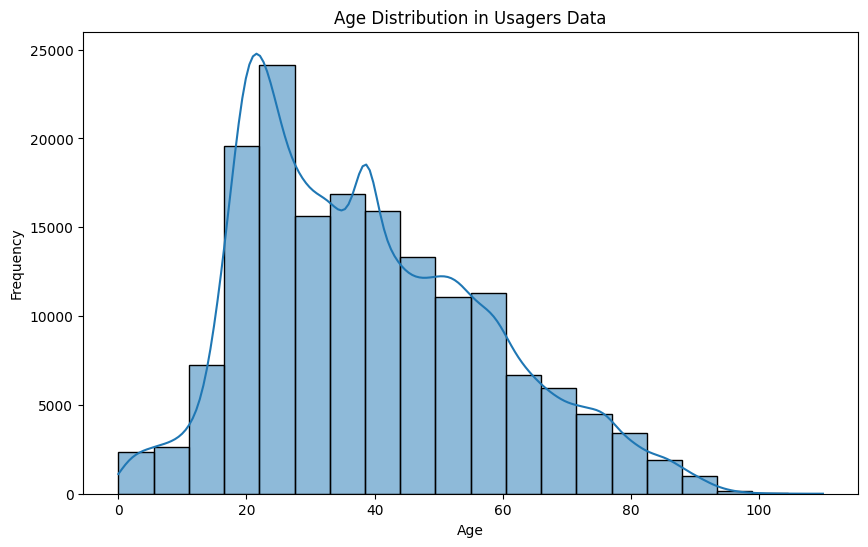

/var/folders/04/kwkdhc7j6216wtw3th1bq9mc0000gn/T/ipykernel_25744/2361671853.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['grav'], palette="viridis")


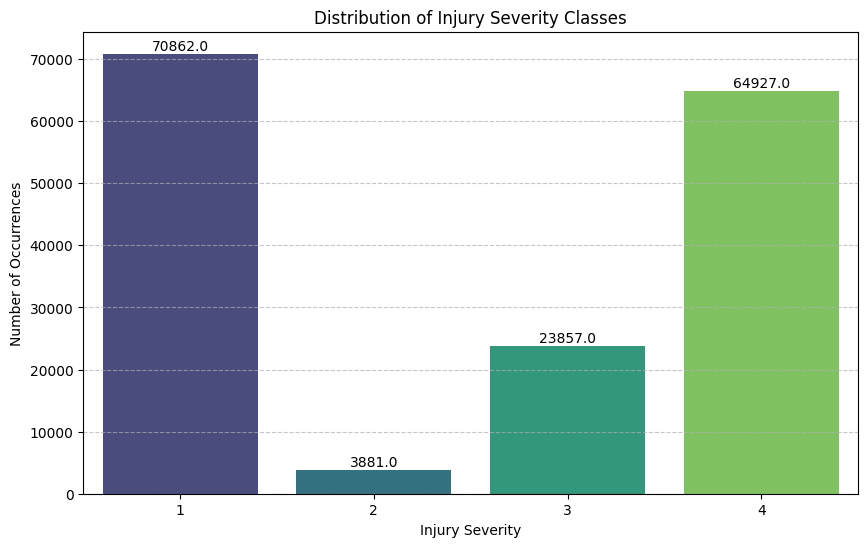

In [20]:
# Visualize the distribution of a numerical column (e.g., age in the 'usagers' dataset)
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Age Distribution in Usagers Data')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of accident severity (categorical column 'grav')
plt.figure(figsize=(10, 6))
sns.countplot(x=df['grav'], palette="viridis")

plt.title("Distribution of Injury Severity Classes")
plt.xlabel("Injury Severity")
plt.ylabel("Number of Occurrences")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

plt.show()


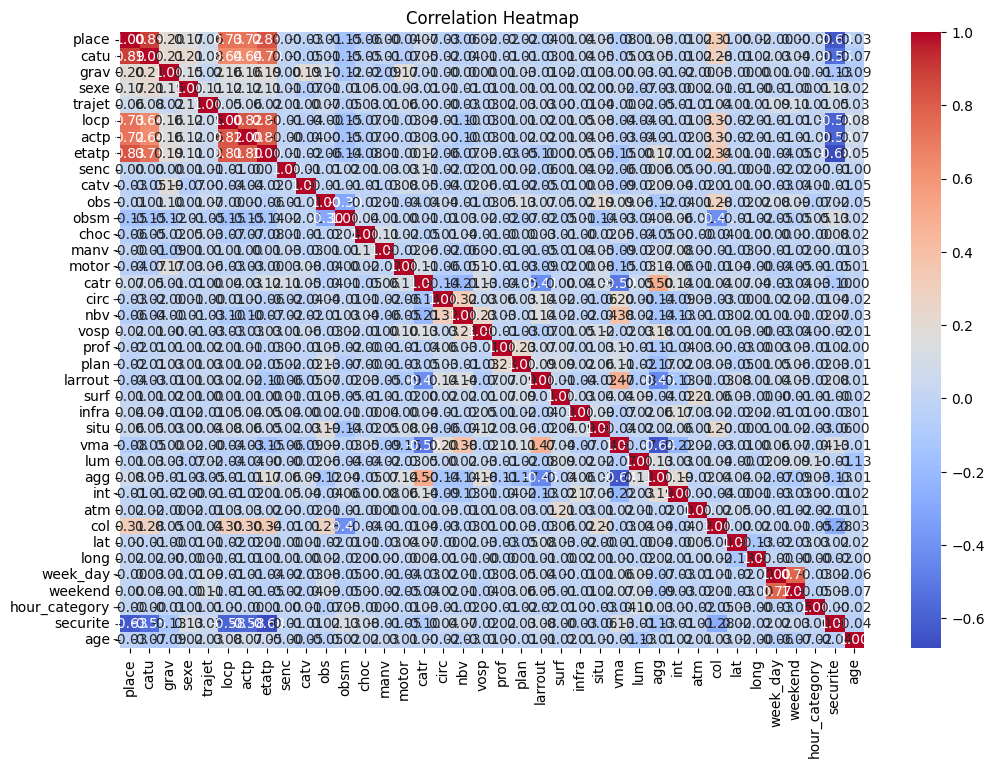

In [21]:
# Select only numeric columns for correlation calculation
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [22]:
# Définition de la cible
y = df["grav"]  

# Sélection de X : toutes les colonnes sauf la target
X = df.drop(columns=["grav"])

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    confusion_matrix, classification_report, balanced_accuracy_score
)

# Définition des colonnes numériques (même si aucune transformation ne sera appliquée)
numerical_cols = X.columns.tolist()

# Pipeline de prétraitement (Passthrough pour conserver les données telles quelles)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols)
    ]
)

# Modèle RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")  

# Pipeline complet
pipeline = make_pipeline(preprocessor, rf_model)

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Métriques de classification adaptées aux données déséquilibrées
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="macro")
precision = precision_score(y_test, y_pred, average="macro")

# Affichage des résultats
print(f" Accuracy : {accuracy:.4f}")
print(f"Balanced Accuracy : {balanced_acc:.4f} (Meilleure métrique pour classes déséquilibrées)")
print(f" F1-score Macro : {f1_macro:.4f}")
print(f" F1-score Weighted : {f1_weighted:.4f}")
print(f" Recall (macro) : {recall:.4f}")
print(f" Precision (macro) : {precision:.4f}")

# Matrice de confusion
print("\n Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Rapport détaillé des performances
print("\nRapport de classification détaillé :")
print(classification_report(y_test, y_pred))

# Importance des features
rf_model = pipeline.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_

# Construction de la liste des features (uniquement numériques)
feature_names = numerical_cols  

# Création du DataFrame d'importance des features
importances_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importances_df = importances_df.sort_values(by="Importance", ascending=False)

print("\n Features les plus importantes :")
print(importances_df.head(10))


 Accuracy : 0.7606
Balanced Accuracy : 0.5892 (Meilleure métrique pour classes déséquilibrées)
 F1-score Macro : 0.6162
 F1-score Weighted : 0.7531
 Recall (macro) : 0.5892
 Precision (macro) : 0.7157

 Matrice de confusion :
[[12474     4   315  1380]
 [   97   143   343   193]
 [  587    53  2627  1504]
 [ 2473    12   870  9631]]

Rapport de classification détaillé :
              precision    recall  f1-score   support

           1       0.80      0.88      0.84     14173
           2       0.67      0.18      0.29       776
           3       0.63      0.55      0.59      4771
           4       0.76      0.74      0.75     12986

    accuracy                           0.76     32706
   macro avg       0.72      0.59      0.62     32706
weighted avg       0.75      0.76      0.75     32706


📌 Features les plus importantes :
     Feature  Importance
36       age    0.089148
30       lat    0.081116
31      long    0.076931
8       catv    0.076774
12      manv    0.040580
11     

In [25]:
# Affichage des 10 features les moins importantes
least_important_features = importances_df.tail(10)  # Sélection des 10 dernières
print("\n📌 10 Features les moins importantes :")
print(least_important_features)



📌 10 Features les moins importantes :
     Feature  Importance
1       catu    0.013608
19      plan    0.013453
23      situ    0.012772
22     infra    0.012598
18      prof    0.012568
21      surf    0.010741
35  securite    0.009839
17      vosp    0.009527
33   weekend    0.009007
6      etatp    0.004265


In [34]:
# Liste des features à garder (exclure les 10 moins importantes)
features_to_keep = importances_df.iloc[:-10]["Feature"].tolist()

# Mise à jour des datasets
X_train_reduced = X_train[features_to_keep]
X_test_reduced = X_test[features_to_keep]
# Recréer un ColumnTransformer avec seulement les features restantes
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', features_to_keep)  # Mettre uniquement les features sélectionnées
    ]
)

# Nouveau pipeline avec le preprocessor mis à jour
pipeline_reduced = make_pipeline(preprocessor_reduced, RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"))

# Entraînement du modèle avec les features réduites
pipeline_reduced.fit(X_train_reduced, y_train)

# Prédictions
y_pred_reduced = pipeline_reduced.predict(X_test_reduced)

# Évaluation des performances
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
balanced_acc_reduced = balanced_accuracy_score(y_test, y_pred_reduced)
f1_macro_reduced = f1_score(y_test, y_pred_reduced, average="macro")
f1_weighted_reduced = f1_score(y_test, y_pred_reduced, average="weighted")

# Affichage des résultats comparatifs
print("\nRésultats AVEC toutes les features :")
print(f" Accuracy : {accuracy:.4f}, Balanced Acc : {balanced_acc:.4f}, F1-macro : {f1_macro:.4f}")

print("\nRésultats SANS les 10 features les moins importantes :")
print(f" Accuracy : {accuracy_reduced:.4f}, Balanced Acc : {balanced_acc_reduced:.4f}, F1-macro : {f1_macro_reduced:.4f}")

# Comparaison des performances
if f1_macro_reduced > f1_macro:
    print("\n Suppression réussie : Le modèle est plus performant ")
else:
    print("\n Suppression inefficace : Les features supprimées étaient peut-être utiles.")


Résultats AVEC toutes les features :
 Accuracy : 0.7606, Balanced Acc : 0.5892, F1-macro : 0.6162

Résultats SANS les 10 features les moins importantes :
 Accuracy : 0.7646, Balanced Acc : 0.5963, F1-macro : 0.6242

 Suppression réussie : Le modèle est plus performant !
